In [1]:
#meta 3/7/2021 Numerai Starter - Linear regression 
#src https://www.kaggle.com/carlolepelaars/how-to-get-started-with-numerai

#history
# 3/7/2021 NUMERAI STARTER: EDA, LINEAR MODEL, EVALUATE METRICS. ROUND 254
#     Cobmined code from multiple sources.
#     Key source for metrics: #src https://www.kaggle.com/carlolepelaars/how-to-get-started-with-numerai
#     Want to understand how to evaluate linear models since we're not using common MSE or RMSE metrics.

# 3/13/2021 NUMERAI STARTER: EDA, LINEAR MODEL, EVALUATE METRICS. ROUND 255

# 3/14/2021 INSTRUMENT WANDB ROUND 255
#     Basic wandb tracking
#     Wandb regression plots take a long time -> reduce to only one
#     $config

# 3/20/2021 ADJUST WANDB ROUND 256
#     Basic wandb tracking
#     Wandb all regression plots take a long time, if reduce to only one or two, error out
#     corr 0.0162
#     $config



In [2]:
# Install Numerai's API
!pip install numerapi
# Get the latest version of Weights and Biases
!pip install wandb --upgrade

# Numerai

In [3]:
import numerapi

import os
import time
import numpy as np
import pandas as pd
# Surpress Pandas warnings
pd.set_option('chained_assignment', None)
import matplotlib.pyplot as plt

import sklearn.linear_model
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr

from joblib import dump, load

from kaggle_secrets import UserSecretsClient
import wandb


In [4]:
'''
import random as rn
import seaborn as sns
import lightgbm as lgb

from wandb.lightgbm import wandb_callback
wandb.login(key=WANDB_KEY)
'''

'\nimport random as rn\nimport seaborn as sns\nimport lightgbm as lgb\n\nfrom wandb.lightgbm import wandb_callback\nwandb.login(key=WANDB_KEY)\n'

In [5]:
# Set global vars
# Initialize Numerai's API
napi = numerapi.NumerAPI(verbosity="info")
NAPI_ROUND = napi.get_current_round()
MODEL = 'model-anyaconda' #$config

# Data directory
DIR = "/kaggle/working"

# Set seed for reproducability
SEED = 1234
#rn.seed(seed)
#np.random.seed(seed)
#os.environ['PYTHONHASHSEED'] = str(seed)


# Weights and Biases
WANDB_LABEL = "my_wandb2"
WANDB_KEY = UserSecretsClient().get_secret(WANDB_LABEL)
##wandb.login(key=WANDB_KEY) -> errors out
WANDB_NOTES = MODEL + "-" + str(NAPI_ROUND)

#track time
t0 = time.time()

In [6]:
!wandb login $WANDB_KEY

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
# Track model with wandb
#wandb.init(settings=wandb.Settings(start_method='thread'))
wandb.init(project = "my-numerai", group = MODEL, name = "round-" + str(NAPI_ROUND), notes = WANDB_NOTES) #entity='anya'


wandb: Currently logged in as: anya (use `wandb login --relogin` to force relogin)


In [8]:
# Define global functions

# get latest data
# src https://www.kaggle.com/carlolepelaars/how-to-get-started-with-numerai
def download_current_data(directory: str):
    """
    Downloads the data for the current round
    :param directory: The path to the directory where the data needs to be saved
    """
    current_round = napi.get_current_round()
    if os.path.isdir(f'{directory}/numerai_dataset_{current_round}/'):
        print(f"You already have the newest data! Current round is: {current_round}")
    else:
        print(f"Downloading new data for round: {current_round}!")
        napi.download_current_dataset(dest_path=directory, unzip=True)

#modified from the original load_data() 
def load_data(directory: str, reduce_memory: bool=True) -> tuple:
    """
    Get data for current round
    :param directory: The path to the directory where the data needs to be saved
    :return: A tuple containing the datasets
    """
    print('Loading the data')
    full_path = f'{directory}/numerai_dataset_{napi.get_current_round()}/'
    train_path = full_path + 'numerai_training_data.csv'
    tournament_path = full_path + 'numerai_tournament_data.csv'
    train = pd.read_csv(train_path)
    tournament = pd.read_csv(tournament_path)
    
    # Reduce all features to 32-bit floats
    if reduce_memory:
        col_features = [f for f in train.columns if f.startswith("feature")]
        train[col_features] = train[col_features].astype(np.float32)
        tournament[col_features] = tournament[col_features].astype(np.float32)
        
    return train, tournament

## 0. Load Data

#### Datasets 
*   `training_data` is used to train your model
*   `tournament_data` is used to evaluate your model

#### Column descriptions
*   id: a randomized id that corresponds to a stock 
*   era: a period of time
*   data_type: either `train`, `validation`, `test`, or `live` 
*   feature_*: abstract financial features of the stock 
*   target: abstract measure of stock performance

In [9]:
#download competition data
##napi.get_current_round()
##napi.download_current_dataset()
download_current_data(DIR)

You already have the newest data! Current round is: 256


In [10]:
#unzip and load
training_data, tournament_data = load_data(DIR, reduce_memory=True)
training_data.shape, tournament_data.shape

Loading the data


((501808, 314), (1676742, 314))

In [11]:
print ("Loading data completed time (in min).  Data downloaded, unzipped and loaded.", (time.time() - t0)/60)

print("Training set info:")
training_data.info()
print("\nTournament set info:")
tournament_data.info()

Loading data completed time (in min).  Data downloaded, unzipped and loaded. 6.249769556522369
Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 314 entries, id to target
dtypes: float32(310), float64(1), object(3)
memory usage: 608.7+ MB

Tournament set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676742 entries, 0 to 1676741
Columns: 314 entries, id to target
dtypes: float32(310), float64(1), object(3)
memory usage: 2.0+ GB


In [12]:
training_data.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


### 0.1 EDA
Distributions, Missing data


In [13]:
training_data.data_type.unique(), tournament_data.data_type.unique()

(array(['train'], dtype=object),
 array(['validation', 'test', 'live'], dtype=object))

In [14]:
training_data['target'].describe(), tournament_data['target'].describe()

(count    501808.000000
 mean          0.499997
 std           0.223268
 min           0.000000
 25%           0.500000
 50%           0.500000
 75%           0.500000
 max           1.000000
 Name: target, dtype: float64,
 count    137779.000000
 mean          0.500015
 std           0.223491
 min           0.000000
 25%           0.500000
 50%           0.500000
 75%           0.500000
 max           1.000000
 Name: target, dtype: float64)

Text(0.5, 1.0, 'Target value - Tournament ds')

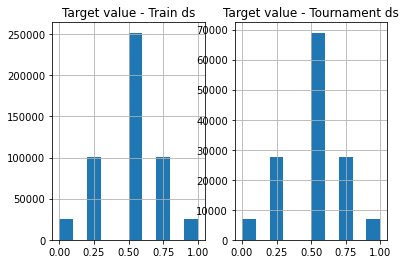

In [15]:
#plot histograms
fig, ax = plt.subplots(1, 2)
training_data['target'].hist(ax=ax[0]); 
tournament_data['target'].hist(ax=ax[1]);
ax[0].set_title('Target value - Train ds')
ax[1].set_title('Target value - Tournament ds')

#### Missing Targets
Train has no missing targets.  
Notice missing targets in tournament dataset: none missing in Valid, all missing in Test and Live.

In [16]:
training_data['target'].value_counts(dropna=False), tournament_data['target'].value_counts(dropna=False)

(0.50    251677
 0.25    100053
 0.75    100045
 1.00     25017
 0.00     25016
 Name: target, dtype: int64,
 NaN     1538963
 0.50      68954
 0.75      27533
 0.25      27531
 1.00       6882
 0.00       6879
 Name: target, dtype: int64)

In [17]:
#check nulls
(training_data['target'].isnull().sum(), training_data['target'].notnull().sum()), (tournament_data['target'].isnull().sum(), tournament_data['target'].notnull().sum())

((0, 501808), (1538963, 137779))

#### Eras: train ds
120 eras in the train dataset.  Era sizes change over time.

In [18]:
training_data['era'].describe()

count     501808
unique       120
top        era58
freq        4893
Name: era, dtype: object

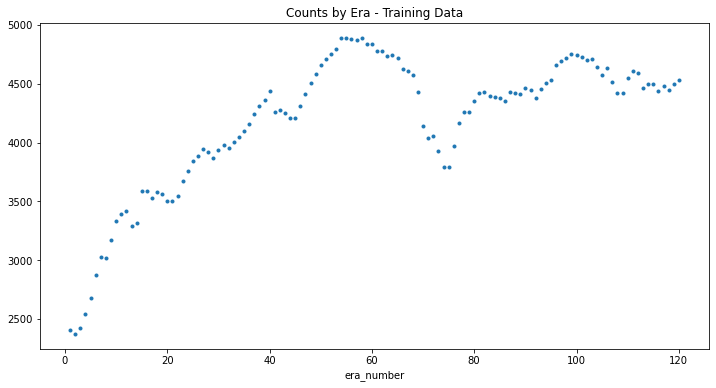

In [19]:
training_data['era_number'] = training_data['era'].str.slice(3).astype(int)
training_data.groupby('era_number')['id'].count().plot(style=".", title= "Counts by Era - Training Data",  figsize=(12, 6));

#### Eras: valid ds
28 eras in the valid dataset. Era sizes change over time.  Gaps in era numbers.

In [20]:
tournament_data[tournament_data.data_type=='validation']['era'].describe()
#df_valid['era_number'] = df_valid['era'].str.slice(3).astype(int)
#df_valid['era'].describe(), df_valid['era_number'].describe()

count     137779
unique        28
top       era210
freq        5227
Name: era, dtype: object

In [21]:
tournament_data[tournament_data.data_type=='validation']['era'].unique()

array(['era121', 'era122', 'era123', 'era124', 'era125', 'era126',
       'era127', 'era128', 'era129', 'era130', 'era131', 'era132',
       'era197', 'era198', 'era199', 'era200', 'era201', 'era202',
       'era203', 'era204', 'era205', 'era206', 'era207', 'era208',
       'era209', 'era210', 'era211', 'era212'], dtype=object)

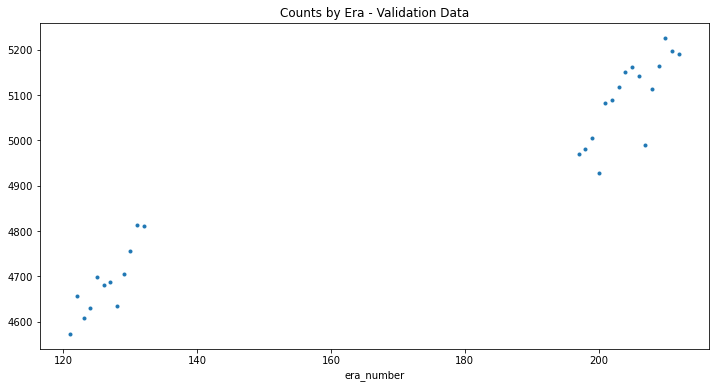

In [22]:
tournament_data['era_number'] = tournament_data[tournament_data.data_type=='validation']['era'].str.slice(3).astype(int)
tournament_data.groupby('era_number')['id'].count().plot(style=".", title= "Counts by Era - Validation Data", figsize=(12, 6));

## 1. Data Prep

In [23]:
#split into datasets
valid_idx = tournament_data.index[tournament_data.data_type=='validation'].tolist()
df_valid = tournament_data.iloc[valid_idx]


X&y
The features are divided into 6 groups: intelligence, wisdom, charisma, dexterity, strength and constitution.

In [24]:
# define the feature columns
col_features = training_data.columns[training_data.columns.str.startswith('feature')]

X_train = training_data[col_features]
y_train = training_data['target']
X_valid = df_valid[col_features]
y_valid = df_valid['target']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((501808, 310), (501808,), (137779, 310), (137779,))

#### Confirm Missing Targets
Train and Valid none are missing, Test and Live all are missing.

In [25]:
#check nulls - numbers must match
(y_train.isnull().sum(), y_train.notnull().sum()), (y_valid.isnull().sum(), y_valid.notnull().sum())

((0, 501808), (0, 137779))

## 2. Model
Start with simplest Linear regression

In [26]:
#track time
t0_model = time.time()

# train a model to make predictions on tournament data
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

t1_model = (time.time() - t0_model)/60
print ("Training time (in min)", t1_model)

Training time (in min) 0.09553541739781697


In [27]:
# Log training time with wandb
wandb.log({"training_time_minutes":t1_model})

In [28]:
#save model
dump(model, "model_anyaconda_e6424243.pkl")

print ("Training completed time (in min).  Model saved.", (time.time() - t0)/60)

Training completed time (in min).  Model saved. 6.57527019182841


## 3. Evaluate Model

In [29]:
def sharpe_ratio(corrs: pd.Series) -> np.float32:
    """
    Calculate the Sharpe ratio for Numerai by using grouped per-era data
    
    :param corrs: A Pandas Series containing the Spearman correlations for each era
    :return: A float denoting the Sharpe ratio of your predictions.
    """
    return corrs.mean() / corrs.std()


def evaluate(df: pd.DataFrame) -> tuple:
    """
    Evaluate and display relevant metrics for Numerai 
    
    :param df: A Pandas DataFrame containing the columns "era", "target" and "prediction"
    :return: A tuple of float containing the metrics
    """
    def _score(sub_df: pd.DataFrame) -> np.float32:
        """Calculates Spearman correlation"""
        return spearmanr(sub_df["target"], sub_df["prediction"])[0]
    
    # Calculate metrics
    corrs = df.groupby("era").apply(_score)
    payout_raw = (corrs / 0.2).clip(-1, 1)
    spearman = round(corrs.mean(), 4)
    payout = round(payout_raw.mean(), 4)
    numerai_sharpe = round(sharpe_ratio(corrs), 4)
    mae = mean_absolute_error(df["target"], df["prediction"]).round(4)

    # Display metrics
    print(f"Spearman Correlation: {spearman}")
    print(f"Average Payout: {payout}")
    print(f"Sharpe Ratio: {numerai_sharpe}")
    print(f"Mean Absolute Error (MAE): {mae}")
    return spearman, payout, numerai_sharpe, mae


In [30]:
# Create predictions from model - on Train and Validation dataset
training_data.loc[:,"prediction"] = model.predict(X_train)
df_valid.loc[:,"prediction"] = model.predict(X_valid)
training_data[['target','prediction']].head(), df_valid[['target','prediction']].head()

(   target  prediction
 0    0.50    0.501301
 1    0.25    0.517580
 2    0.25    0.495422
 3    0.25    0.506792
 4    0.75    0.498840,
    target  prediction
 0    0.25    0.481608
 1    0.50    0.492837
 2    1.00    0.530817
 3    0.50    0.497083
 4    0.75    0.503089)

In [31]:
# Evaluate Model
print("--- Final Training Scores ---")
spearman, payout, numerai_sharpe, mae = evaluate(training_data)
# Log train metrics with wandb
wandb.log({"spearman_train":spearman, "payout_train":payout, "numerai_sharpe_train":numerai_sharpe, "mae_train": mae })

print("\n--- Final Validation Scores ---")
spearman, payout, numerai_sharpe, mae = evaluate(df_valid)
# Log validation metrics with wandb
wandb.log({"spearman_valid":spearman, "payout_valid":payout, "numerai_sharpe_valid":numerai_sharpe, "mae_valid": mae })


--- Final Training Scores ---
Spearman Correlation: 0.0528
Average Payout: 0.2642
Sharpe Ratio: 1.6928
Mean Absolute Error (MAE): 0.1537

--- Final Validation Scores ---
Spearman Correlation: 0.0162
Average Payout: 0.0812
Sharpe Ratio: 0.5237
Mean Absolute Error (MAE): 0.1543


In [32]:
print ("Evaluation completed time (in min).  Models evaluated: train and validation datasets.", (time.time() - t0)/60)

Evaluation completed time (in min).  Models evaluated: train and validation datasets. 6.628785888353984


In [33]:
# Log plots with wandb
#All regression plots
wandb.sklearn.plot_regressor(model, X_train[:10000], X_valid[:10000], y_train[:10000], y_valid[:10000]) #,  model_name=MODEL

#Or Make individual plots #$config
#wandb.sklearn.plot_summary_metrics(model, X_train, X_valid, y_train, y_valid)
#wandb.sklearn.plot_learning_curve(model, X_train, X_valid, y_train, y_valid)
#wandb.sklearn.plot_outlier_candidates(model, X_train, y_train)
#wandb.sklearn.plot_residuals(model, X_train, y_train)

wandb: 
wandb: Plotting Regressor.
wandb: Logged summary metrics.
wandb: Logged learning curve.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: Logged outlier candidates.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: Logged residuals.


#### Visualize Targets vs Predictions

Text(0.5, 1.0, 'Target value - Validation ds')

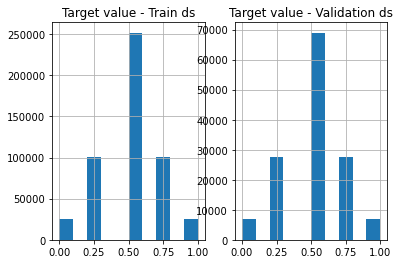

In [34]:
#plot histograms
fig, ax = plt.subplots(1, 2)
training_data['target'].hist(ax=ax[0]); 
df_valid['target'].hist(ax=ax[1]);
ax[0].set_title('Target value - Train ds')
ax[1].set_title('Target value - Validation ds')

Text(0.5, 1.0, 'Prediction value - Validation ds')

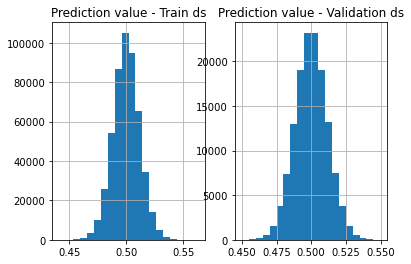

In [35]:
#plot histograms
fig, ax = plt.subplots(1, 2)
training_data['prediction'].hist(ax=ax[0], bins=20); 
df_valid['prediction'].hist(ax=ax[1], bins=20);
ax[0].set_title('Prediction value - Train ds')
ax[1].set_title('Prediction value - Validation ds')

In [36]:
count_train, division_train = np.histogram(training_data['prediction'], bins=20)
count_valid, division_valid = np.histogram(df_valid['prediction'], bins=20)
print ("Training data\n", count_train, division_train)
print ("Validation data\n", count_valid, division_valid)


Training data
 [     9     44    220    937   3286  10091  25958  54182  86573 105164
  94615  65473  34437  14190   4829   1416    310     60     10      4] [0.44121325 0.44729397 0.45337468 0.45945537 0.4655361  0.4716168
 0.47769752 0.48377824 0.48985893 0.49593964 0.50202036 0.50810105
 0.5141818  0.5202625  0.5263432  0.5324239  0.5385046  0.54458535
 0.55066603 0.5567468  0.56282747]
Validation data
 [   16    58   165   554  1580  3756  7419 12990 18993 23210 23216 19005
 13166  7499  3783  1556   588   157    56    12] [0.4500818  0.4550703  0.46005878 0.46504727 0.47003576 0.47502425
 0.48001274 0.48500124 0.48998973 0.49497822 0.49996674 0.50495523
 0.5099437  0.5149322  0.5199207  0.5249092  0.5298977  0.5348862
 0.5398747  0.54486316 0.54985166]


In [37]:
#Combine 
# Log target distributions with wandb
wandb.log({"target_prediction_valid": wandb.Histogram(df_valid['target'])})
wandb.log({"target_prediction_train": wandb.Histogram(training_data['target'])})
# Log prediction distributions with wandb
wandb.log({"target_prediction_valid": wandb.Histogram(df_valid['prediction'])})
wandb.log({"target_prediction_train": wandb.Histogram(training_data['prediction'])})

Free up some memory

In [39]:
#get all dfs
# Simply evaluate and test whether they are pandas dataframes
alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(alldfs)

['X_train', 'X_valid', '_12', 'df_valid', 'tournament_data', 'training_data']


In [40]:
import gc
print(gc.get_count())
del [[X_train, X_valid, _12]] #$config
gc.collect()
print(gc.get_count())

#remaining dfs
alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(alldfs)

(569, 3, 6)
(24, 0, 0)
['df_valid', 'tournament_data', 'training_data']


## 4.0 Predict for Submission
Not evaluating full tournamanet ds, due to no values in `target` field.

In [41]:
# define the feature columns
X_tournament = tournament_data[col_features]
y_tournament = tournament_data['target']

X_tournament.shape, y_tournament.shape

((1676742, 310), (1676742,))

View predictions: head and 3 tails (live, test, prev test)

In [42]:
tournament_data.loc[:,"prediction"] = model.predict(X_tournament)
tournament_data[['target','prediction']].head()

,target,prediction
0,0.25,0.418098
1,0.50,0.451163
2,1.00,0.650815
3,0.50,0.460642
4,0.75,0.509951


In [43]:
# submit predictions to numer.ai - manually?
tournament_data[["id", "prediction"]].to_csv("predictions.csv", index=False)

print ("Submission dataset completed time (in min).  Submission saved to csv.", (time.time() - t0)/60)

Submission dataset completed time (in min).  Submission saved to csv. 8.743247826894125


## Appendix

### Appendix A. Submission Post-EDA

#### Eras: tournament ds
330 eras total in the tournament dataset. Era sizes change over time. We already know about gaps in era numbers in valid ds (not visible in the plot below due to volume)

In [44]:
tournament_data['era_number'] = tournament_data['era'].str.slice(3) #.astype(int)
tournament_data['era'].describe(), tournament_data['era_number'].describe()

(count     1676742
 unique        331
 top          eraX
 freq         5433
 Name: era, dtype: object,
 count     1676742
 unique        331
 top             X
 freq         5433
 Name: era_number, dtype: object)

In [45]:
print("Training: ", training_data['era'].describe()[1], (training_data['era_number'].min(), training_data['era_number'].max()))
print("Tournamnet: ", tournament_data['era'].describe()[1], (tournament_data['era_number'].min(), tournament_data['era_number'].max()))
#print("Tournamnet - validation: ", df_valid['era'].describe()[1], (tournament_data[tournament_data['data_type']=='validation']['era_number'].min(), tournament_data[tournament_data['data_type']=='validation']['era_number'].max()))
print("Tournamnet - validation: ", df_valid['era'].describe()[1], (df_valid['era_number'].min(), df_valid['era_number'].max()))

df_tourn_test = tournament_data[tournament_data['data_type']=='test']
df_tourn_live = tournament_data[tournament_data['data_type']=='live']
print("Tournamnet - test: ", df_tourn_test['era'].describe()[1], (df_tourn_test['era_number'].min(), df_tourn_test['era_number'].max()))
print("Tournamnet - live: ", df_tourn_live['era'].describe()[1], (df_tourn_live['era_number'].min(), df_tourn_live['era_number'].max()))

Training:  120 (1, 120)
Tournamnet:  331 ('121', 'X')
Tournamnet - validation:  28 (121.0, 212.0)
Tournamnet - test:  302 ('575', '950')
Tournamnet - live:  1 ('X', 'X')


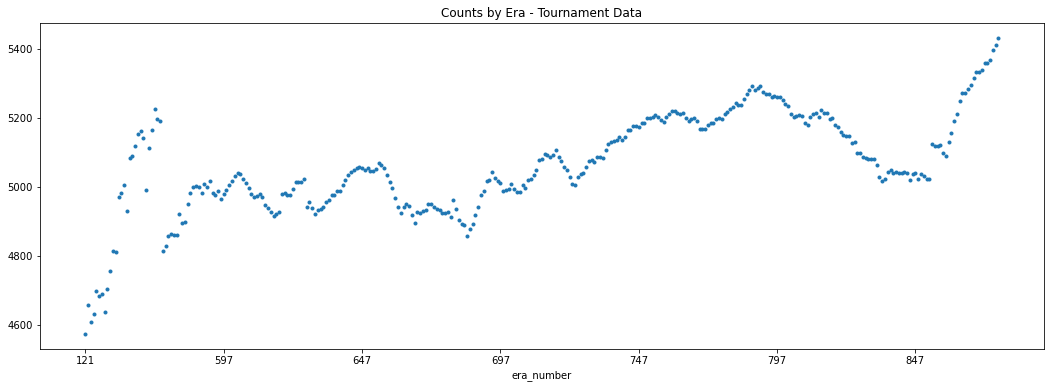

In [46]:
tournament_data.groupby('era_number')['id'].count().plot(style = ".", title= "Counts by Era - Tournament Data",  figsize=(18, 6));

In [47]:
# Log eras with wandb
wandb.log({"eras_train":(training_data['era'].describe()[1], (training_data['era_number'].min(), training_data['era_number'].max())), "eras_tourn":(tournament_data['era'].describe()[1], (tournament_data['era_number'].min(), tournament_data['era_number'].max())), "eras_valid":(df_valid['era'].describe()[1], (df_valid['era_number'].min(), df_valid['era_number'].max())), "eras_test": (df_tourn_test['era'].describe()[1], (df_tourn_test['era_number'].min(), df_tourn_test['era_number'].max())), "eras_live": (df_tourn_live['era'].describe()[1], (df_tourn_live['era_number'].min(), df_tourn_live['era_number'].max())) })


#### Predictions

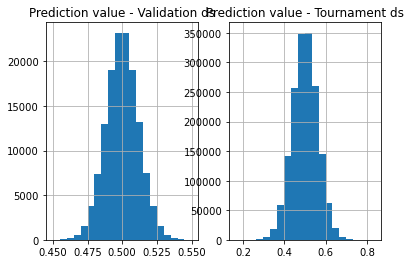

In [48]:
#plot histograms
fig, ax = plt.subplots(1, 2)
df_valid['prediction'].hist(ax=ax[0], bins=20);
tournament_data['prediction'].hist(ax=ax[1], bins=20);
ax[0].set_title('Prediction value - Validation ds');
ax[1].set_title('Prediction value - Tournament ds');

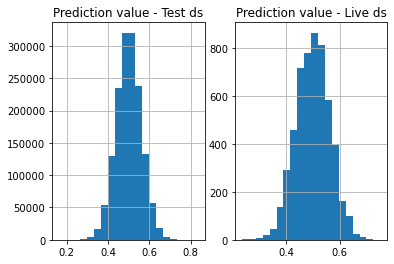

In [49]:
#plot histograms
fig, ax = plt.subplots(1, 2)
tournament_data[tournament_data['data_type']=='test']['prediction'].hist(ax=ax[0], bins=20);
tournament_data[tournament_data['data_type']=='live']['prediction'].hist(ax=ax[1], bins=20);
ax[0].set_title('Prediction value - Test ds');
ax[1].set_title('Prediction value - Live ds');

In [50]:
count_tourn, division_tourn = np.histogram(tournament_data['prediction'], bins=20)
count_valid, division_valid = np.histogram(df_valid['prediction'], bins=20)
count_test, division_test = np.histogram(df_tourn_test['prediction'], bins=20)
count_live, division_live = np.histogram(df_tourn_live['prediction'], bins=20)

print ("Tournament data\n", count_tourn.sum(), count_tourn, division_tourn)
print ("Validation data\n", count_valid.sum(), count_valid, division_valid)
print ("Test data\n", count_test.sum(), count_test, division_test)
print ("Live data\n", count_live.sum(), count_live, division_live)

Tournament data
 1676742 [     9     23    187    915   4692  18793  59368 141271 257040 349019
 350353 260488 145117  62037  20507   5460   1163    249     43      8] [0.16361955 0.19714431 0.23066907 0.26419383 0.29771858 0.33124337
 0.36476812 0.39829287 0.43181765 0.4653424  0.49886715 0.5323919
 0.5659167  0.59944147 0.6329662  0.666491   0.7000157  0.7335405
 0.7670653  0.80059004 0.8341148 ]
Validation data
 137779 [   16    58   165   554  1580  3756  7419 12990 18993 23210 23216 19005
 13166  7499  3783  1556   588   157    56    12] [0.4500818  0.4550703  0.46005878 0.46504727 0.47003576 0.47502425
 0.48001274 0.48500124 0.48998973 0.49497822 0.49996674 0.50495523
 0.5099437  0.5149322  0.5199207  0.5249092  0.5298977  0.5348862
 0.5398747  0.54486316 0.54985166]
Test data
 1533530 [     8     19    170    835   4324  17251  54229 129153 234950 319400
 320528 238232 132504  56775  18796   4989   1080    237     42      8] [0.16361955 0.19714431 0.23066907 0.26419383 0.2977185

In [51]:
# Log ds counts with wandb
wandb.log({"count_train":training_data.shape[0], "count_tourn":count_tourn.sum(), "count_valid":count_valid.sum(), "count_test": count_test.sum(), "count_live": count_live.sum() })


In [52]:
# Log prediction distributions with wandb
wandb.log({"prediction_tourn": wandb.Histogram(tournament_data['prediction'])})
wandb.log({"prediction_test": wandb.Histogram(df_tourn_test['prediction'])})
wandb.log({"prediction_live": wandb.Histogram(df_tourn_live['prediction'])})

#### Previous Test
should be the same as the whole `test` during last round

In [53]:
era_test_max = int(tournament_data[tournament_data['data_type']=='test']['era_number'].max())
df_tourn_test_prev = df_tourn_test[df_tourn_test['era_number'] != str(era_test_max)]

print("Tournamnet - previous test: ", df_tourn_test_prev['era_number'].min(), df_tourn_test_prev['era_number'].max())

Tournamnet - previous test:  575 949


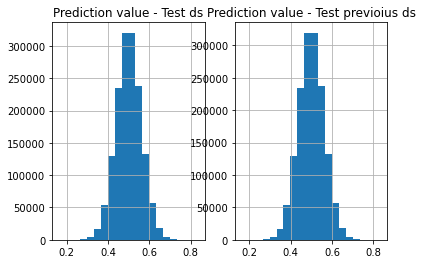

In [54]:
#plot histograms
fig, ax = plt.subplots(1, 2)
df_tourn_test['prediction'].hist(ax=ax[0], bins=20);
df_tourn_test_prev['prediction'].hist(ax=ax[1], bins=20);
ax[0].set_title('Prediction value - Test ds');
ax[1].set_title('Prediction value - Test previoius ds');

In [55]:
count_test_prev, division_test_prev = np.histogram(df_tourn_test_prev['prediction'], bins=20)
print ("Test data\n", count_test.sum(), count_test, division_test)
print ("Test data - previous\n", count_test_prev.sum(), count_test_prev, division_test_prev)

Test data
 1533530 [     8     19    170    835   4324  17251  54229 129153 234950 319400
 320528 238232 132504  56775  18796   4989   1080    237     42      8] [0.16361955 0.19714431 0.23066907 0.26419383 0.29771858 0.33124337
 0.36476812 0.39829287 0.43181765 0.4653424  0.49886715 0.5323919
 0.5659167  0.59944147 0.6329662  0.666491   0.7000157  0.7335405
 0.7670653  0.80059004 0.8341148 ]
Test data - previous
 1528119 [     8     19    169    828   4308  17183  54022 128666 234143 318351
 319428 237373 131976  56576  18730   4975   1077    237     42      8] [0.16361955 0.19714431 0.23066907 0.26419383 0.29771858 0.33124337
 0.36476812 0.39829287 0.43181765 0.4653424  0.49886715 0.5323919
 0.5659167  0.59944147 0.6329662  0.666491   0.7000157  0.7335405
 0.7670653  0.80059004 0.8341148 ]


Note: with 20 bins, bins are the same, counts are slightly different - smaller in previous test ds.

#### Predictions: tournament vs test vs previous test

In [56]:
print("Predictions tail: live", tournament_data[['target','prediction']].tail())
print("Predictions tail: test", df_tourn_test[['target','prediction']].tail())
print("Predictions tail: test previous", df_tourn_test_prev[['target','prediction']].tail())

Predictions tail: live          target  prediction
1676737     NaN    0.485292
1676738     NaN    0.456024
1676739     NaN    0.485208
1676740     NaN    0.523321
1676741     NaN    0.414160
Predictions tail: test          target  prediction
1671304     NaN    0.424169
1671305     NaN    0.478008
1671306     NaN    0.411808
1671307     NaN    0.483861
1671308     NaN    0.452045
Predictions tail: test previous          target  prediction
1665893     NaN    0.516528
1665894     NaN    0.424081
1665895     NaN    0.431493
1665896     NaN    0.568127
1665897     NaN    0.504053


In [57]:
wandb.finish()

training_time_minutes,0.09554
_runtime,538
_timestamp,1616322632
_step,15
spearman_train,0.0528
payout_train,0.2642
numerai_sharpe_train,1.6928
mae_train,0.1537
spearman_valid,0.0162
payout_valid,0.0812
numerai_sharpe_valid,0.5237


training_time_minutes,▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂█████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂█████
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
spearman_train,▁
payout_train,▁
numerai_sharpe_train,▁
mae_train,▁
spearman_valid,▁
payout_valid,▁
numerai_sharpe_valid,▁


In [58]:
mystop = 1

## Xtra

In [59]:
if not mystop:
    
    def load_data0(directory: str, reduce_memory: bool=True) -> tuple:
        """
        Get data for current round
        :param directory: The path to the directory where the data needs to be saved
        :return: A tuple containing the datasets
        """
        print('Loading the data')
        full_path = f'{directory}/numerai_dataset_{NAPI.get_current_round()}/'
        train_path = full_path + 'numerai_training_data.csv'
        test_path = full_path + 'numerai_tournament_data.csv'
        train = pd.read_csv(train_path)
        test = pd.read_csv(test_path)

        # Reduce all features to 32-bit floats
        if reduce_memory:
            num_features = [f for f in train.columns if f.startswith("feature")]
            train[num_features] = train[num_features].astype(np.float32)
            test[num_features] = test[num_features].astype(np.float32)

        val = test[test['data_type'] == 'validation']
        return train, val, test